# Generate initial designs for training data for ART

### TODO

[] Use ART to make initial designs

In [1]:
import numpy as np
import pandas as pd
from random import randrange
import matplotlib.pyplot as plt
from pyDOE import *

All genes we might consider in relation to isopentenol production:

In [2]:
# genes = ['ACCOAC', 
#          'POX', # zero flux
#          'PTAr', 
#          'CS', 
#          'ACACT1R', 
#          'PPC', # zero flux
#          'PPCK', 
#          'PFL', # zero flux
#          'PYK', 
#          'MDH']

In [3]:
genes = ['ACCOAC', 
         'POX', # zero flux
         'PTAr', 
         'CS', 
         'ACACT1R', 
         'PPCK',
         'PYK', 
         'MDH',
         'PFL', # zero flux
         'PPC'] # zero flux

Types of genetic modifications: 
- knockout (KO)
- no modification (NoMod)
- doubling the expression (UP)

In [4]:
modif_dict = {'KO': 0, 
              'NoMod': 1,
              'UP': 2}

How many genes you want to consider?

In [6]:
n_genes = int(input())


 7


How many instances you want to generate?

In [7]:
n_instances = int(input())

 48


In [8]:
n_modifications = len(modif_dict)
genes = genes[:n_genes]
tot_number_mod = n_modifications**n_genes
print(f'Total number of possible modifications: {tot_number_mod}')
trainingset = n_instances/tot_number_mod*100
print(f'Training set size: {n_instances} ({trainingset:.2f}%)')

Total number of possible modifications: 2187
Training set size: 48 (2.19%)


In [9]:
df = pd.DataFrame(columns=genes)
df.insert(loc=0, column='Line Name', value=None)

Define wild type strain with no modifications:

In [10]:
df.loc[0] = ['WT'] + [modif_dict['NoMod'] for i in range(n_genes)] 
df

,Line Name,ACCOAC,POX,PTAr,CS,ACACT1R,PPCK,PYK
0,WT,1,1,1,1,1,1,1


### Assign designs for the training set randomly (uniformly distributed among the options)

In [11]:
for i in range(1,n_instances):
    df.loc[i] = [str(i)] + [randrange(3) for i in range(n_genes)]
                            
df.head()

,Line Name,ACCOAC,POX,PTAr,CS,ACACT1R,PPCK,PYK
0,WT,1,1,1,1,1,1,1
1,1,1,1,2,0,0,1,1
2,2,0,2,2,1,2,1,2
3,3,1,2,0,0,0,0,1
4,4,0,0,0,2,2,0,2


How many modifications 'introduced' into each strain?

In [12]:
def num_of_modifications(df):
    num_instances = len(df)
    values = np.empty(num_instances)
    for i in range(num_instances):
        design = df.loc[i][1:]
        values[i] = list(design).count(0) + list(design).count(2)
    return values
            

In [13]:
df['# Modifs'] = num_of_modifications(df)
df.head()

,Line Name,ACCOAC,POX,PTAr,CS,ACACT1R,PPCK,PYK,# Modifs
0,WT,1,1,1,1,1,1,1,0.0
1,1,1,1,2,0,0,1,1,3.0
2,2,0,2,2,1,2,1,2,5.0
3,3,1,2,0,0,0,0,1,5.0
4,4,0,0,0,2,2,0,2,7.0


Find distribution of modifications per gene in the training data set:

In [14]:
df.loc[n_instances] = ['Summary'] + [[list(df[gene]).count(int(i))/n_instances*100 
                                            for i in range(n_modifications)]  for gene in genes] + [np.mean(df['# Modifs'])]
df.iloc[-1]

Line Name                                              Summary
ACCOAC       [39.58333333333333, 33.33333333333333, 27.0833...
POX               [25.0, 39.58333333333333, 35.41666666666667]
PTAr         [29.166666666666668, 35.41666666666667, 35.416...
CS              [29.166666666666668, 20.833333333333336, 50.0]
ACACT1R           [33.33333333333333, 41.66666666666667, 25.0]
PPCK         [29.166666666666668, 41.66666666666667, 29.166...
PYK            [27.083333333333332, 43.75, 29.166666666666668]
# Modifs                                                4.4375
Name: 48, dtype: object

In [15]:
def plot_distribution(dataframe): 
    bar_height = 1
    labels = ['KO', 'NoMod', 'UP']
    colors = ['#019600', 'grey', '#219AD8']

    data = [ [dataframe[dataframe['Line Name']=='Summary'][g].values[0][num] for g in genes] 
            for num in range(n_modifications)]
    y_pos = np.arange(len(genes))

    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111)

    # Remove frame
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    patch_handles = []
    # left alignment of data starts at zero
    left = np.zeros(len(genes)) 
    for i, d in enumerate(data):
        patch_handles.append(ax.barh(y_pos, d, 
                                     color=colors[i%len(colors)], edgecolor='white',
                                     height=bar_height, align='center', 
                                     left=left, label=labels[i]))
        left += d

    # search all of the bar segments and annotate
    for j in range(n_modifications):
        for i, patch in enumerate(patch_handles[j].get_children()):
            bl = patch.get_xy()
            x = 0.5*patch.get_width() + bl[0]
            y = 0.5*patch.get_height() + bl[1]
            ax.text(x,y, "%d%%" % (data[j][i]), ha='center')

    ax.set_title('Distribution of modifications')
    plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='on', 
                    labelbottom='off')
    plt.yticks(y_pos, genes)
    ax.invert_yaxis()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


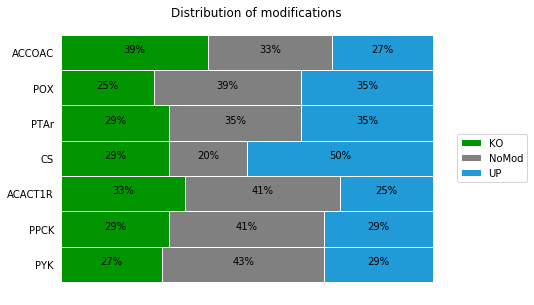

In [16]:
plot_distribution(df)

Save training set:

In [17]:
df.loc[0:n_instances].to_csv(f'./data/training_data_{n_genes}genes_unif.csv', 
                             columns = ['Line Name'] + genes, 
                             header = True, index = False)

### Assign designs for the training set using Latin Hypercube sampling

In [18]:
df_lhs = df.copy()
df_lhs = df_lhs[df.columns[:-1]]
df_lhs.head()

,Line Name,ACCOAC,POX,PTAr,CS,ACACT1R,PPCK,PYK
0,WT,1,1,1,1,1,1,1
1,1,1,1,2,0,0,1,1
2,2,0,2,2,1,2,1,2
3,3,1,2,0,0,0,0,1
4,4,0,0,0,2,2,0,2


In [19]:
latin_hc = lhs(n_genes, samples=n_instances-1, criterion='maximin')
latin_hc = np.floor(3 * latin_hc)

for i in range(1,n_instances):
    designs = list(latin_hc[(i-1)])
    df_lhs.loc[i] = [str(i)] + designs 

df_lhs['# Modifs'] = num_of_modifications(df_lhs)

df_lhs.head()

,Line Name,ACCOAC,POX,PTAr,CS,ACACT1R,PPCK,PYK,# Modifs
0,WT,1,1,1,1,1,1,1,0.0
1,1,1,2,0,2,1,1,0,4.0
2,2,0,2,0,2,2,1,0,6.0
3,3,1,0,1,0,0,1,2,4.0
4,4,2,1,0,1,1,0,1,3.0


In [20]:
df_lhs.loc[n_instances] = ['Summary'] + [[list(df_lhs[gene]).count(int(i))/n_instances*100 
                                            for i in range(n_modifications)]  for gene in genes] + [np.mean(df_lhs['# Modifs'])]
df_lhs.iloc[-1]

Line Name                                              Summary
ACCOAC           [31.25, 35.41666666666667, 33.33333333333333]
POX              [31.25, 35.41666666666667, 33.33333333333333]
PTAr         [33.33333333333333, 33.33333333333333, 33.3333...
CS           [33.33333333333333, 33.33333333333333, 33.3333...
ACACT1R          [31.25, 35.41666666666667, 33.33333333333333]
PPCK         [33.33333333333333, 33.33333333333333, 33.3333...
PYK              [33.33333333333333, 35.41666666666667, 31.25]
# Modifs                                                4.4898
Name: 48, dtype: object

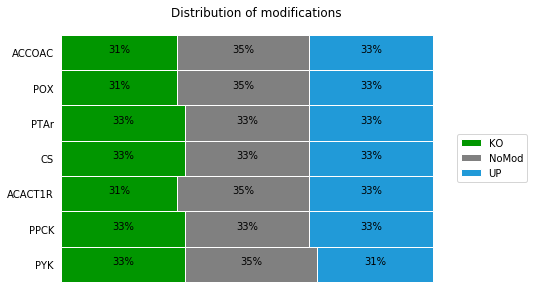

In [21]:
plot_distribution(df_lhs)

Save training set:

In [22]:
df.loc[0:n_instances].to_csv(f'./data/training_data_{n_genes}genes_lhs.csv', 
                             columns = ['Line Name'] + genes, 
                             header = True, index = False)